In [15]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import dLux as dl
from matplotlib import colors, pyplot as plt
import jax.numpy as np
from jax import jit

import webbpsf
import pysiaf
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm

Array = np.ndarray

In [2]:
from dLuxWebbpsf import NIRCamCoron

In [3]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

<Figure size 640x480 with 0 Axes>

In [4]:
source_offset_x = 0.1 * np.pi / 648000
source_offset_y = 0.0 * np.pi / 648000

In [5]:
def get_osys(instrument, filtr, pup_mask, crn_mask, detector, aperture):
    webb_osys = getattr(webbpsf, instrument)()
    webb_osys.filter = filtr
    webb_osys.pupil_mask = pup_mask
    webb_osys.image_mask = crn_mask
    webb_osys.detector = detector

    # Siaf aperture
    aper = pysiaf.Siaf(instrument)[aperture]
    webb_osys.set_position_from_aperture_name(aperture)
    
    return webb_osys

In [6]:
webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

def get_nircam(source_offset_x = 0, source_offset_y = 0):
    webb_osys = get_osys("NIRCam", "F300M", "CIRCLYOT", "MASK430R", "NRCA5", "NRCA5_FULL_MASK430R") #same as nc.
    webb_osys.options.update(webb_options)
    
    source_offset_r = np.sqrt(source_offset_x**2+ source_offset_y**2)
    source_offset_theta = np.arctan2(source_offset_y, source_offset_x)*180/np.pi
    
    #print(source_offset_r)
    #print(source_offset_theta)
    
    #print(source_offset_r * np.sin(source_offset_theta/180*np.pi))
    #print(source_offset_r * np.cos(source_offset_theta/180*np.pi))
    
    webb_osys.options['source_offset_r'] = source_offset_r
    webb_osys.options['source_offset_theta'] = source_offset_theta
    
    return webb_osys

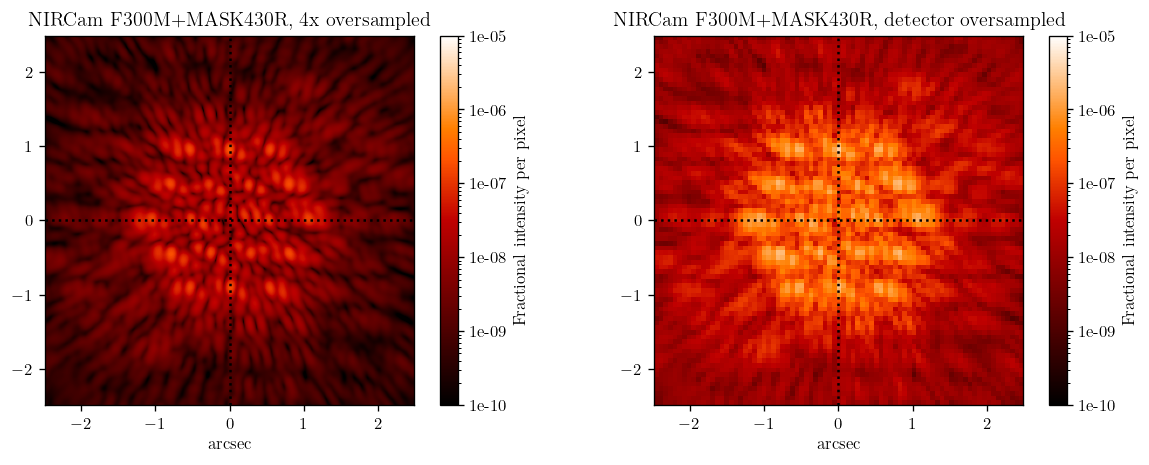

In [7]:
webb_osys = get_nircam()

webb_osys.calc_psf('coronagraphic.fits', oversample=4) #, monochromatic=3.0e-6)   # create highly oversampled output image

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='OVERSAMP', title='NIRCam F300M+MASK430R, 4x oversampled', crosshairs=True)
plt.subplot(1,2,2)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='DET_SAMP', title='NIRCam F300M+MASK430R, detector oversampled', crosshairs=True)

#plt.savefig('example_nircam_coron_resampling.png')

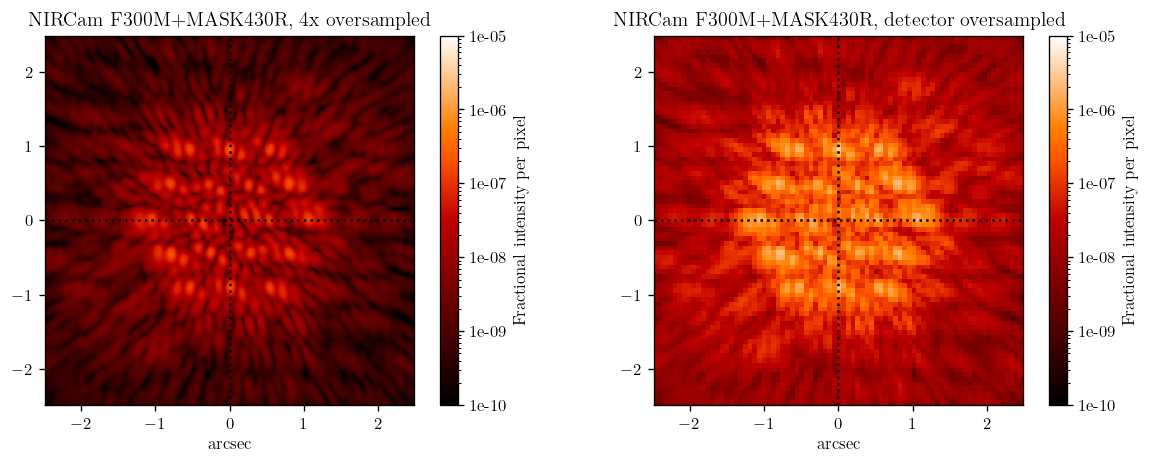

In [8]:
webb_osys = get_nircam(source_offset_x, source_offset_y)

webb_osys.calc_psf('coronagraphic_planet.fits', oversample=4) #, monochromatic=3.0e-6)   # create highly oversampled output image

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
webbpsf.display_psf('coronagraphic_planet.fits', vmin=1e-10, vmax=1e-5,
    ext='OVERSAMP', title='NIRCam F300M+MASK430R, 4x oversampled', crosshairs=True)
plt.subplot(1,2,2)
webbpsf.display_psf('coronagraphic_planet.fits', vmin=1e-10, vmax=1e-5,
    ext='DET_SAMP', title='NIRCam F300M+MASK430R, detector oversampled', crosshairs=True)

#plt.savefig('example_nircam_coron_resampling.png')

In [9]:
# webb_osys.calc_psf?

In [7]:
from astropy.io import fits

hdul = fits.open('coronagraphic.fits')
hdul.info()

webbpsf_header = hdul[0].header
webbpsf_data_star = hdul[0].data

hdul.close()

Filename: coronagraphic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     123   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       124   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       168   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       169   (79, 79)   float64   


In [8]:
hdul_planet = fits.open('coronagraphic_planet.fits')
hdul_planet.info()

webbpsf_data_planet = hdul_planet[0].data

hdul_planet.close()

Filename: coronagraphic_planet.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     124   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       125   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       169   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       170   (79, 79)   float64   


In [9]:
webbpsf_data = webbpsf_data_star + webbpsf_data_planet/100.

In [10]:
webbpsf_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  316                                                  
NAXIS2  =                  316                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 2.98203115618662E-06 / Weighted mean wavelength in meters             
DIFFLMT =  0.08833256135803114 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=              0.01575 / Scale in arcsec/pix (after oversampling)       
FOV     =                4.9

In [11]:
#generating source from fits file

head = webbpsf_header
nwavels = head['NWAVES']
wavels, weights = [], []
for i in range(nwavels):
    wavels.append(head['WAVE'+str(i)])
    weights.append(head['WGHT'+str(i)])

spec = dl.Spectrum(wavels, weights)

# wavelengths are still required even if they are discarded
source = dl.PointSource(wavelengths=wavels, spectrum=spec, position=np.array([-source_offset_y / 648000.0 * np.pi, -source_offset_x / 648000.0 * np.pi]))


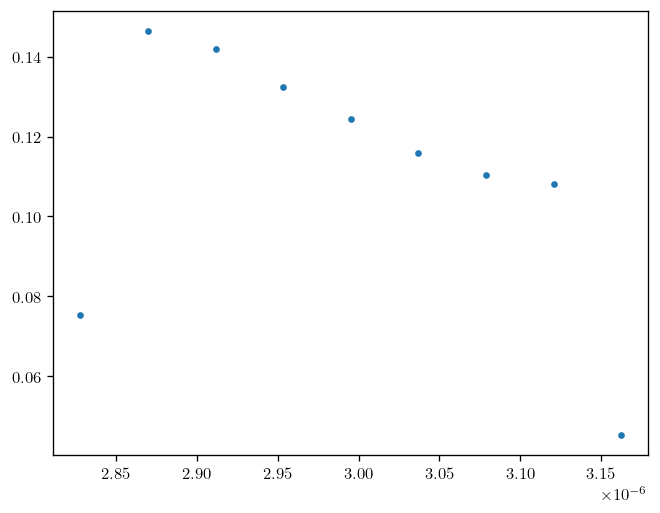

In [12]:
plt.plot(spec.wavelengths,spec.weights,'.')

In [13]:
optics = NIRCamCoron(filter = "F300M",
                     pupil_mask = "CIRCLYOT",
                     coron_mask = "MASK430R",
                     detector = "NRCA5",
                     aperture = "NRCA5_FULL_MASK430R",
                     fft_oversample=4,
                     options=webb_options)

opd_ref_focus: {} 6.714345736893632e-08
tilt_ref_offset: {} 5.412406381286715e-08


In [16]:
%%time
print("Modelling optics...")
#psf = optics.model(sources=source)
psf = optics.propagate(wavels, weights=weights)
print("Modelling optics...ok")
psf_norm = psf/psf.sum()
webbpsf_norm = webbpsf_data/webbpsf_data.sum()

norm = colors.LogNorm(vmin=1e-10, vmax=1e-5)
vmin = 1e-10
vmax = 1e-5
ticks = np.logspace(np.log10(vmin), np.log10(vmax), int(np.round(np.log10(vmax / vmin) + 1)))


Modelling optics...
Modelling optics...ok
CPU times: user 23.9 s, sys: 27.4 s, total: 51.3 s
Wall time: 29.5 s


In [1]:
@jit
def test():
    return optics.model(source=source)

test()

NameError: name 'jit' is not defined

In [21]:
%%time 

test()

CPU times: user 28.3 s, sys: 1.3 s, total: 29.6 s
Wall time: 10.9 s


DeviceArray([[1.64755457e-10, 1.32579252e-10, 1.05808293e-10, ...,
              1.26950584e-10, 1.22090509e-10, 1.11114265e-10],
             [1.68046114e-10, 1.38251266e-10, 1.10569882e-10, ...,
              1.31894788e-10, 1.24559741e-10, 1.10297966e-10],
             [1.65246128e-10, 1.40148037e-10, 1.14199668e-10, ...,
              1.37536982e-10, 1.28492062e-10, 1.12472569e-10],
             ...,
             [1.37701577e-10, 1.33148631e-10, 1.24983467e-10, ...,
              1.03312230e-10, 9.86560943e-11, 9.45519110e-11],
             [1.07143430e-10, 1.05814168e-10, 1.02209217e-10, ...,
              1.10697678e-10, 1.09870022e-10, 1.08205311e-10],
             [8.75479684e-11, 8.96252564e-11, 9.03622248e-11, ...,
              1.17034043e-10, 1.20912945e-10, 1.23412827e-10]],            dtype=float64)

In [23]:
webbpsf_data = webbpsf_data_planet
webbpsf_norm = webbpsf_data/webbpsf_data.sum()

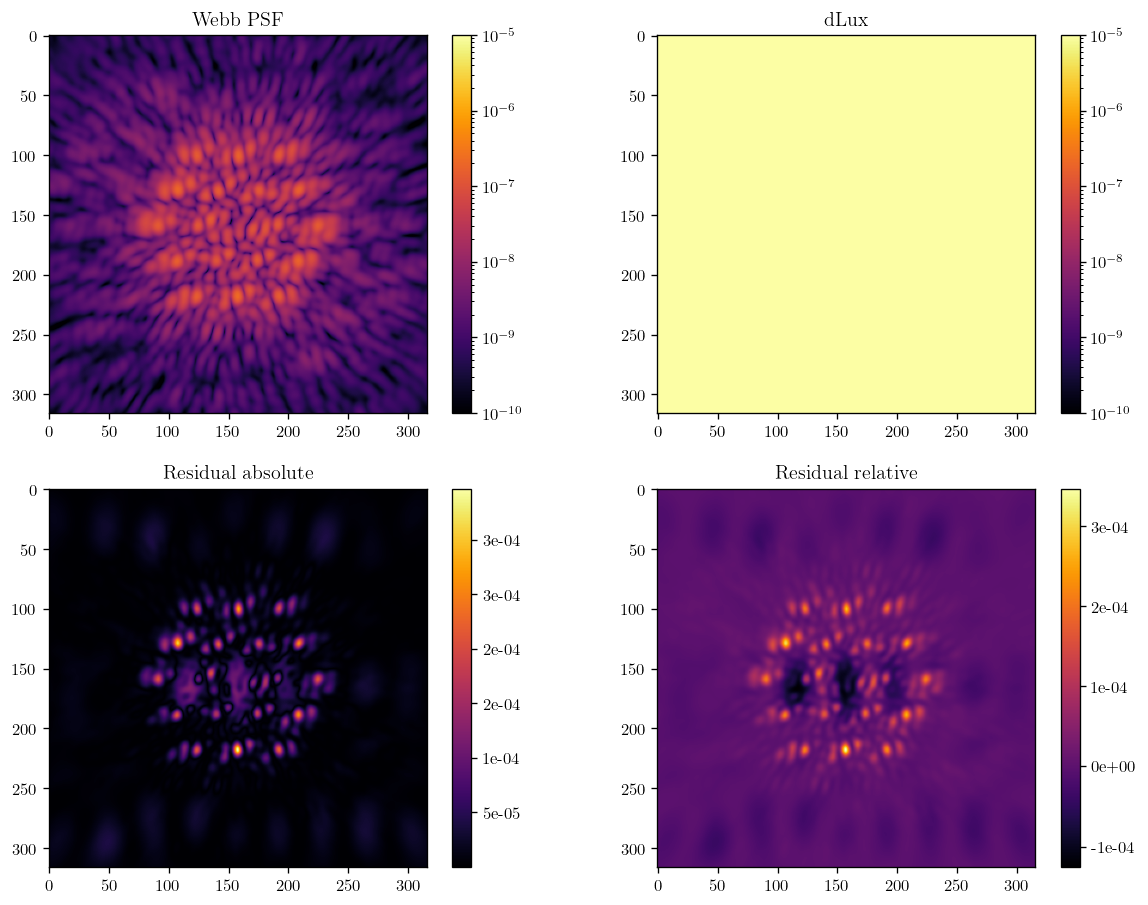

In [17]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.title("Webb PSF")
plt.imshow(webbpsf_data, norm=norm)
bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

plt.subplot(2, 2, 2)
plt.title("dLux")
plt.imshow(psf, norm=norm)
bar2 = plt.colorbar()
#bar2.set_ticks(ticks)
#bar2.set_ticklabels(ticks)

plt.subplot(2, 2, 3)
plt.title("Residual absolute")
plt.imshow(abs(webbpsf_norm - psf_norm))
# plt.imshow(webbpsf_norm/psf_norm)
plt.colorbar(format='%.0e')

plt.subplot(2, 2, 4)
plt.title("Residual relative")
plt.imshow(webbpsf_norm - psf_norm)
# plt.imshow(webbpsf_norm/psf_norm)
plt.colorbar(format='%.0e')

#mse = (np.sqrt((webbpsf_norm - psf_norm)**2)).max()
#print(mse)